# Abstract 
content

# Introduction
content

# Data 
content

In [3]:
# imports
import pandas as pd
import os 
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from pylab import cm
import seaborn as sns
import scipy.stats as stats
import math
from matplotlib.patches import Ellipse
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
from keras import metrics
from keras import Sequential
from keras.layers import Dropout, ReLU


PATH = '/Users/ingmarvandergeest/Documents/Education/Block 4/Pattern Recognition/Projects'
FILENAME = 'mnist.csv'


dataset = pd.read_csv(os.path.join(PATH, FILENAME))
features = dataset.iloc[:,1:] 
labels = dataset.iloc[:,0]

# Exploratory

Before we start training classification models we first explore the dataset to get a better understanding of what the dataset entails, perhaps there are certain patterns that can already be recognized by simply looking at certain representations of the data. 

The first thing that stands out is that some of the pixels have a maximum value of 0, in other words: in all 42k examples, they are never once inked in. In total about 10% of the pixels are never inked in and therefore dont contain any information. In graph xxx the black colored pixels are pixels that are never once colored in. 

Another thing that stands out is that the sum of many pixels is near 0 (less than 1% of all samples), and most of the inked pixels are concentrated in the center area. When using 1% of samples as a boundary to draw new bounds, the size of the image will go from 28x28 to 25x23. In graph xxx black and dark gray colored pixels identify this border. 

We go one step further and look at the deviation of the normalized mean value per class for each pixel. Here it becomes apparent which pixels have a high distinctive value. Here the assumption is made that when the average values of two classes are far apart, they are easier to distinguish. 

Last but not least we look at the normalized means for each class individually to see what areas contain a disproportionately large or small amount of samples for that class. The red colored areas are areas that are positively correlated with that particular class, in contrast, the blue colored areas are inversely correlated. 

Now that we know what our data looks like and where the important features are, we can start processing the data, with the first step being to factorise the labels. From one column that contains the labels to n columns that correspond to the n labels. In this case it will be 10 columns, one column for each digit. 

76
0.7250238095238095


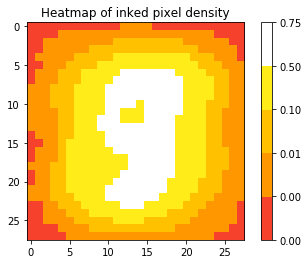

In [2]:
# explore 1, max values = 0
total_sum = features.astype(bool).astype(int)
total_sum = total_sum.sum(axis=0) / 42000


print(total_sum.value_counts()[0])
print(total_sum.max())

cmap = colors.ListedColormap(['#F6412D','#FF9800', '#FFC100','#FFEC19', 'white'])
boundaries = [0, np.finfo(float).eps, 0.01,0.1,0.5, 0.75]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

image = total_sum
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap=cmap, norm=norm)
plt.colorbar()
plt.title('Heatmap of inked pixel density')
plt.show()

75.98609836171535 0.0


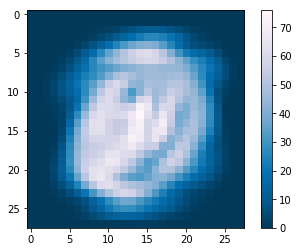

In [3]:
# calculate means for each pixel (each column)
total_means = features.mean(axis=0)


grouped_means = dataset.groupby('label').mean()

corrected_means = grouped_means - total_means

corrected_sd = corrected_means.std()

print(corrected_sd.max(), corrected_sd.min())

image = corrected_sd
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='PuBu_r')
plt.colorbar()
plt.show()

NameError: name 'handles' is not defined

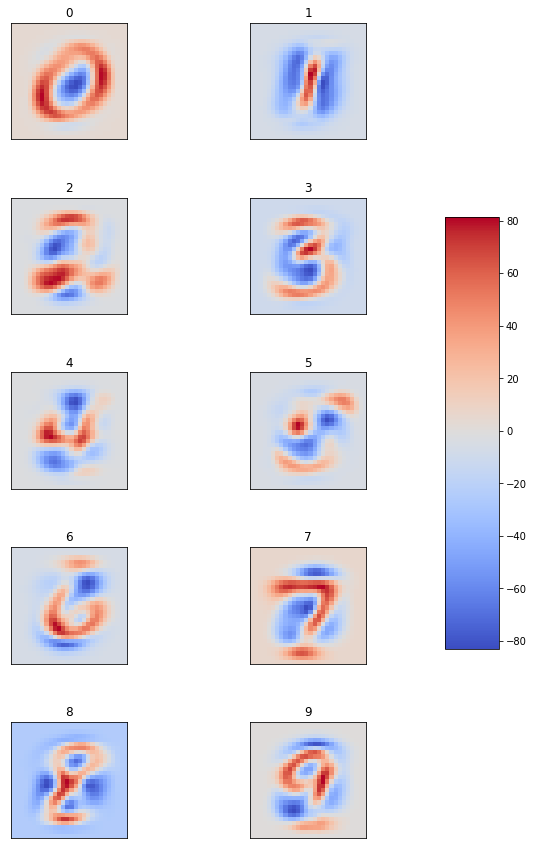

In [4]:

# calculate mean per pixel per number

fig = plt.figure(figsize=(15,15))

for i, row in corrected_means.iterrows():
    ax = plt.subplot(5,2,i+1)
    ax.set_title(i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    image = corrected_means.loc[i]
    image = np.array(image, dtype='float')
    pixels = image.reshape((28, 28))
    ax = plt.imshow(pixels, cmap='coolwarm')

cbar_ax = fig.add_axes([0.75, 0.30, 0.05, 0.4])
fig.colorbar(ax, cax=cbar_ax)
fig.subplots_adjust(wspace=-0.6, hspace=0.5)
fig.legend(handles, labels, loc='right')
fig.suptitle('Normalized means of pixel density within each digit', y=0.95)
plt.savefig('subplot.png', bbox_inches='tight')
plt.show()




# Ink Density

Derive from the raw pixel data a feature that quantifies "how much ink" a digit costs. Report the average and standard deviation of this feature within each class. If you look at these statistics, can you see which pairs of classes can be distinguished well, and which pairs will be hard to distinguish using this feature? Hint: Use the R function "tapply" to compute the mean and standard deviation per digit. If your feature is called "density", then "tapply(density,mnist.dat[,1],mean)" will compute the mean density for each digit.

             ink
label           
0      44.173989
1      19.373044
2      38.100892
3      36.122689
4      30.909085
5      32.953980
6      35.376170
7      29.249036
8      38.500189
9      31.318559


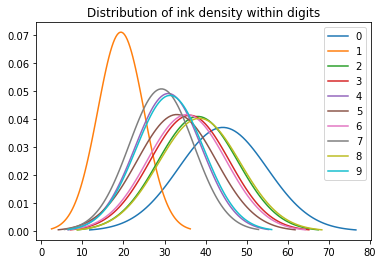

In [5]:
# ink density
ink_cost = pd.DataFrame(features.mean(axis=1), columns=['ink'])
ink_cost_labeled = ink_cost.join(labels)

ink_means = ink_cost_labeled.groupby('label').mean()
ink_std = ink_cost_labeled.groupby('label').std()

print(ink_means)

for i, j in ink_means.iterrows():
    mu = ink_means.loc[i]
    sigma = ink_std.loc[i]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=i)

plt.legend()
plt.title('Distribution of ink density within digits')
plt.savefig('ink.png')
plt.show()





14.0


/Users/ingmarvandergeest/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


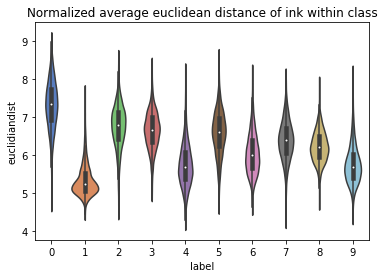

In [6]:
# euclidian distance

reshaped = np.array(features).reshape(-1, 28, 28) / 255
gen_mean = pd.DataFrame(reshaped.mean(axis=(1,2)), columns=['mean'])

# sqrt 14-x ^ 2     14-y ^ 2
# empty array 28 * 28
distances = np.zeros(shape=(28,28))

center_x = distances.shape[0]/2
center_y = distances.shape[1]/2
print(center_x)
for i in np.arange(distances.shape[0]):
    for j in np.arange(distances.shape[1]):
        distances[j,i] = np.hypot(i-center_x+0.5, j-center_y+0.5)

# multiply reshaped for each sample with euclidian distantiator
distance_pixels = distances * reshaped
means = pd.DataFrame(distance_pixels.mean(axis=(1,2)), columns=['euclidiandist'])
norm_means = np.divide(means, gen_mean)

eucl_labeled = norm_means.join(labels)

eucl_means = eucl_labeled.groupby('label').mean()
eucl_std = eucl_labeled.groupby('label').std()

#for i, j in eucl_means.iterrows():
#    mu = eucl_means.loc[i]
#    sigma = eucl_std.loc[i]
#    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=i)
    
fig = sns.violinplot(x='label', y='euclidiandist', data=eucl_labeled, palette='muted')
fig.set_title('Normalized average euclidean distance of ink within class')
fig = fig.get_figure()
#fig.savefig('violin.png')


# Additional Feature
addition to "density", come up with one other feature, and explain why you think it might discriminate well between the digits. Your report should contain an unambiguous description of how the feature is derived from the raw data. 

# Multinomial Logit Model
Using only the density feature, fit a multinomial logit model and evaluate, by looking at the confusion matrix, how well this model can distinguish between the different classes. Since in this part of the assignment we only consider very simple models, you may use the complete data set both for training and evaluation. For example, how well can the model distinguish between the digits "1" and "8"? And how well between "3" and "8"? Use the R function "scale" to scale your feature before you apply "multinom" to fit the multinomial logit model

Also fit using additional feature, and fit using both features, do comparison. 

convergence after 12 epochs took 0 seconds
             precision    recall  f1-score   support

          0       0.25      0.59      0.35      4132
          1       0.44      0.82      0.57      4684
          2       0.14      0.08      0.10      4177
          3       0.12      0.24      0.16      4351
          4       0.00      0.00      0.00      4072
          5       0.00      0.00      0.00      3795
          6       0.00      0.00      0.00      4137
          7       0.15      0.39      0.22      4401
          8       0.00      0.00      0.00      4063
          9       0.13      0.05      0.08      4188

avg / total       0.13      0.23      0.16     42000

0.22676190476190478


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
/Users/ingmarvandergeest/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


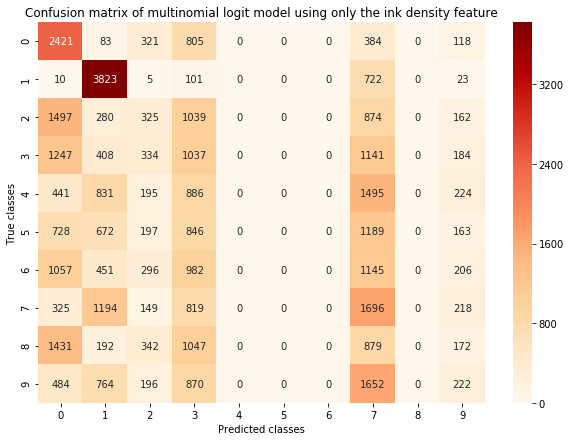

In [76]:
# density data
dens_data = scale(ink_cost)

# labels
#print(labels.shape)

# init model
clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', verbose=1).fit(dens_data, labels)
preds = clf.predict(dens_data)
conf = confusion_matrix(labels, preds)
rep = classification_report(labels, preds)
acc = accuracy_score(labels, preds)

conf = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(conf, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap="OrRd")
ax.set_title('Confusion matrix of multinomial logit model using only the ink density feature')
ax.set(ylabel='True classes', xlabel='Predicted classes')

print(rep)
print(acc)

fig = ax.get_figure()
fig.savefig('density_cm.png')

convergence after 13 epochs took 1 seconds
             precision    recall  f1-score   support

          0       0.42      0.68      0.52      4132
          1       0.43      0.78      0.55      4684
          2       0.21      0.18      0.19      4177
          3       0.20      0.23      0.21      4351
          4       0.00      0.00      0.00      4072
          5       0.00      0.00      0.00      3795
          6       0.15      0.18      0.16      4137
          7       0.18      0.29      0.22      4401
          8       0.20      0.02      0.03      4063
          9       0.21      0.29      0.24      4188

avg / total       0.20      0.27      0.22     42000

0.2731190476190476


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
/Users/ingmarvandergeest/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


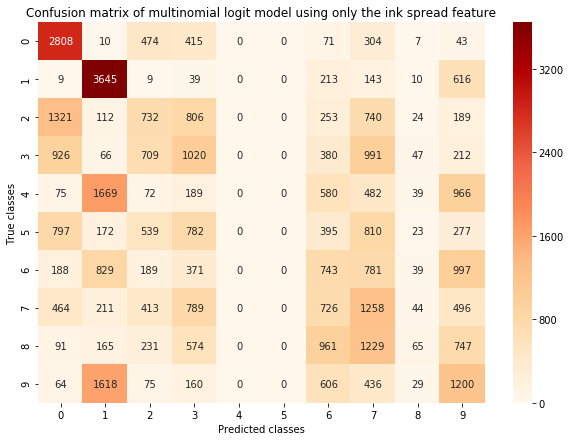

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# euclidean data
eucl_data = scale(norm_means)
#print(norm_means)

# labels
#print(labels.shape)

# init model
clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', verbose=1).fit(eucl_data, labels)
preds = clf.predict(eucl_data)
rep = classification_report(labels, preds)
acc = accuracy_score(labels, preds)

conf = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(conf, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap="OrRd")
ax.set_title('Confusion matrix of multinomial logit model using only the ink spread feature')
ax.set(ylabel='True classes', xlabel='Predicted classes')

print(rep)
print(acc)

fig = ax.get_figure()
fig.savefig('spread_cm.png')

convergence after 13 epochs took 1 seconds
             precision    recall  f1-score   support

          0       0.46      0.69      0.55      4132
          1       0.55      0.81      0.66      4684
          2       0.22      0.15      0.18      4177
          3       0.21      0.16      0.18      4351
          4       0.23      0.03      0.06      4072
          5       0.15      0.01      0.02      3795
          6       0.18      0.12      0.14      4137
          7       0.26      0.49      0.34      4401
          8       0.27      0.32      0.29      4063
          9       0.28      0.42      0.33      4188

avg / total       0.29      0.33      0.28     42000

0.32957142857142857


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


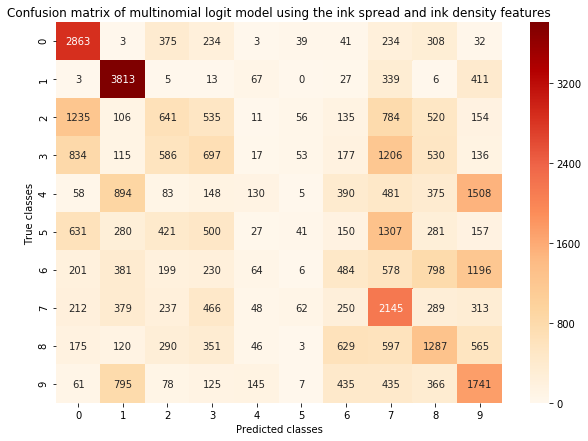

In [79]:
combined_data = np.column_stack((eucl_data, dens_data))

clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', verbose=1).fit(combined_data, labels)
preds = clf.predict(combined_data)
conf = confusion_matrix(labels, preds)
rep = classification_report(labels, preds)
acc = accuracy_score(labels, preds)

conf = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(conf, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap='OrRd')
ax.set_title('Confusion matrix of multinomial logit model using the ink spread and ink density features')
ax.set(ylabel='True classes', xlabel='Predicted classes')

print(rep)
print(acc)

fig = ax.get_figure()
fig.savefig('combined_cm.png')

# Data pre processing
Draw a random sample of size 5,000 from the data, and use these 5,000 examples for training and model selection (using cross-validation). Estimate the error of the models finally selected on the remaining 37,000 examples.

You may reduce the level of detail to, for example, a 14x14 pixel image (the function "down_sample_image" from the "OpenImageR" package may come in very handy here). In that case you will have only 196 features instead of 784.
If you choose to do so, indicate this clearly in the report.

In [4]:
# make train and test datasets

#dataset = pd.read_csv(os.path.join(PATH, FILENAME))
#features = dataset.iloc[:,1:] 
#labels = dataset.iloc[:,0]

train_z = dataset.sample(n=5000, random_state=0)
test_z = pd.concat([dataset, train_z]).drop_duplicates(keep=False)

train_x = train_z.iloc[:,1:] / 255
train_y = train_z.iloc[:,0]

test_x = test_z.iloc[:,1:] / 255
test_y = test_z.iloc[:,0]

print(train_x.describe())

       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
count  5000.0  5000.0  5000.0  5000.0  5000.0  5000.0  5000.0  5000.0  5000.0   
mean      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
std       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
min       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel9    ...        pixel774     pixel775     pixel776     pixel777  \
count  5000.0    ...     5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.0    ...        0.000580     0.000226     0.000150     0.000100   
std       0.0    ...        0.018

# Model comparison
You should analyse the data with:

the regularized multinomial logit model (using the LASSO penalty),
support vector machines,
feed-forward neural networks.
Make sure you use the same sample for training and model selection for each algorithm.
Otherwise the comparison wouldn't be fair!
For each classification method that you apply, discuss the following:

What are the complexity parameters of the classification algorithm, and how did you select their values?
What is the estimated accuracy of the best classifier for this method?

## multinomial logit
What are the complexity parameters of the classification algorithm, and how did you select their values?
What is the estimated accuracy of the best classifier for this method?
For these experiments, you should train models with different parameter settings, and use cross-validation to select the best parameter setting. Use the remaining data to produce an honest estimate of the accuracy of the model finally selected for each method. For example, the complexity parameter for the regularized multinomial logit model with LASSO penalty is "lambda". Try different values of "lambda" and use cross-validation to pick the value that produces the smallest classification error. This is exactly what the R function "cv.glmnet" does for you, so we made it easy for you! Finally, to produce an unbiased estimate of the error for the value of "lambda" selected, compute its classification error on the remaining data. To perform cross-validation for the support vector machine and neural network, you can use the functions "tune.svm" and "tune.nnet" from the "e1071" package respectively.


In [114]:
# classifier initialization
clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial', n_jobs=2, max_iter=500)

# parameters
params = {'C': [1.0, 0.8, 0.6, 0.4]}

# parameter optimization
grid = GridSearchCV(clf,params, cv=5, verbose=3, n_jobs=2)
clf = grid.fit(train_x, train_y)

# prediction
preds = clf.predict(test_x)

# scoring
rep = classification_report(test_y, preds)
acc = accuracy_score(test_y, preds)

# prints
print(clf.best_params_)
print(rep, acc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=1.0 ...........................................................
[CV] ................... C=1.0, score=0.897410358565737, total=  58.6s
[CV] C=1.0 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.6s remaining:    0.0s


[CV] .................. C=1.0, score=0.8802395209580839, total=  47.4s
[CV] C=1.0 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV] ............................... C=1.0, score=0.892, total= 1.1min
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.8797595190380761, total= 1.1min
[CV] C=1.0 ...........................................................
[CV] ................... C=1.0, score=0.892570281124498, total= 1.1min
[CV] C=0.8 ...........................................................
[CV] ................... C=0.8, score=0.900398406374502, total=  51.7s
[CV] C=0.8 ...........................................................
[CV] .................. C=0.8, score=0.8812375249500998, total=  46.9s
[CV] C=0.8 ...........................................................
[CV] ............................... C=0.8, score=0.893, total=  54.8s
[CV] C=0.8 ...........................................................
[CV] .................. C=0.8, score=0.8807615230460922, total=  52.3s
[CV] C=0.8 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 15.8min finished


{'C': 0.4}
             precision    recall  f1-score   support

          0       0.94      0.96      0.95      3638
          1       0.92      0.97      0.95      4120
          2       0.90      0.86      0.88      3676
          3       0.87      0.87      0.87      3829
          4       0.91      0.91      0.91      3562
          5       0.87      0.83      0.85      3363
          6       0.93      0.94      0.94      3636
          7       0.91      0.92      0.91      3848
          8       0.87      0.82      0.85      3620
          9       0.85      0.89      0.87      3708

avg / total       0.90      0.90      0.90     37000
 0.8985405405405406


## SVM
What are the complexity parameters of the classification algorithm, and how did you select their values?
What is the estimated accuracy of the best classifier for this method?
For these experiments, you should train models with different parameter settings, and use cross-validation to select the best parameter setting. Use the remaining data to produce an honest estimate of the accuracy of the model finally selected for each method. For example, the complexity parameter for the regularized multinomial logit model with LASSO penalty is "lambda". Try different values of "lambda" and use cross-validation to pick the value that produces the smallest classification error. This is exactly what the R function "cv.glmnet" does for you, so we made it easy for you! Finally, to produce an unbiased estimate of the error for the value of "lambda" selected, compute its classification error on the remaining data. To perform cross-validation for the support vector machine and neural network, you can use the functions "tune.svm" and "tune.nnet" from the "e1071" package respectively.


In [5]:
# classifier initialization
clf = SVC(random_state=0)

# parameters
params = {'C': [1.0, 0.8, 0.6, 0.4]}

# parameter optimization
grid = GridSearchCV(clf,params, cv=5, verbose=3)
clf = grid.fit(train_x, train_y)

# prediction
preds = clf.predict(test_x)

# scoring
rep = classification_report(test_y, preds)
acc = accuracy_score(test_y, preds)

# prints
print(clf.best_params_)
print(rep, acc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.9123505976095617, total=  10.5s
[CV] C=1.0 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.4s remaining:    0.0s


[CV] .................. C=1.0, score=0.8962075848303394, total=  10.3s
[CV] C=1.0 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.4s remaining:    0.0s


[CV] ............................... C=1.0, score=0.902, total=  11.6s
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.8987975951903807, total=  10.8s
[CV] C=1.0 ...........................................................
[CV] .................. C=1.0, score=0.8995983935742972, total=  11.0s
[CV] C=0.8 ...........................................................
[CV] .................. C=0.8, score=0.9083665338645418, total=  13.3s
[CV] C=0.8 ...........................................................
[CV] .................. C=0.8, score=0.8902195608782435, total=  11.2s
[CV] C=0.8 ...........................................................
[CV] ............................... C=0.8, score=0.897, total=  14.3s
[CV] C=0.8 ...........................................................
[CV] .................. C=0.8, score=0.8937875751503006, total=  13.1s
[CV] C=0.8 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.6min finished


{'C': 1.0}
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      3638
          1       0.90      0.98      0.94      4120
          2       0.93      0.87      0.90      3676
          3       0.88      0.87      0.88      3829
          4       0.89      0.92      0.90      3562
          5       0.87      0.86      0.86      3363
          6       0.92      0.96      0.94      3636
          7       0.92      0.91      0.92      3848
          8       0.91      0.84      0.88      3620
          9       0.87      0.87      0.87      3708

avg / total       0.91      0.91      0.90     37000
 0.9054054054054054


## FFNN
What are the complexity parameters of the classification algorithm, and how did you select their values?
What is the estimated accuracy of the best classifier for this method?
For these experiments, you should train models with different parameter settings, and use cross-validation to select the best parameter setting. Use the remaining data to produce an honest estimate of the accuracy of the model finally selected for each method. For example, the complexity parameter for the regularized multinomial logit model with LASSO penalty is "lambda". Try different values of "lambda" and use cross-validation to pick the value that produces the smallest classification error. This is exactly what the R function "cv.glmnet" does for you, so we made it easy for you! Finally, to produce an unbiased estimate of the error for the value of "lambda" selected, compute its classification error on the remaining data. To perform cross-validation for the support vector machine and neural network, you can use the functions "tune.svm" and "tune.nnet" from the "e1071" package respectively.


# Comparison
Which classification method(s) produced the best classifier for this problem?
After step 3 you will have determined the best parameter settings for each algorithm, and you will have applied the algorithm with these parameter settings to the complete training sample to produce a model. Furthermore you will have estimated the error of these models on the remaining data. Now compare the accuracies of these three models, and perform a statistical test to see if there are any significant differences between their accuracies.

# Conclusion

content

# Discussion

content